In [ ]:
import os
import shutil
import torch
import torchaudio
from tqdm import tqdm
from IPython.display import Audio
from audio_process import AudioProcessor, compute_STFT
from datasets import SpecDataset
from utils import normalize_spec, denormalize_spec, power_to_db, db_to_power, plot_spectrogram

In [2]:
ds = SpecDataset(noisy_dir='./noise_enhance/data/noisy_testset',
                 gt_dir='./noise_enhance/data/clean_testset',
                 device='cuda')
n_fft = 1024
hopsamp = 512 #n_fft // 8
n_mels = 128
processor = AudioProcessor(n_fft, n_mels, 16000)

/storage/users/nguy1432/anaconda3/envs/cGAN/lib/python3.8/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


In [3]:
# what output should be
wav, sr = torchaudio.load('./noise_enhance/data/clean_testset/p226_024.wav')
print(wav.shape, wav.device, sr)

max_len = 64000 + 64*40
signal = wav
signal = signal[:, :min(signal.shape[1], max_len)]  # cut by time axis
# pad_if_necessary, pad with 0
num_missing_samples = max(0, max_len - signal.shape[1])
wav = torch.nn.functional.pad(signal, (0, num_missing_samples), value=0)

mel_spec, _, _ = processor.wav_to_melspec(wav)

wav.shape, mel_spec.shape,

torch.Size([1, 115254]) cpu 16000


(torch.Size([1, 66560]), torch.Size([1, 128, 512]))

In [97]:
wav, sr = torchaudio.load('./noise_enhance/data/clean_testset/p226_024.wav')
print(wav.shape, wav.device, sr)

n_fft = 1024
hopsamp = n_fft // 8
n_mels = 128
processor = AudioProcessor(n_fft, n_mels, sr)

mel_spec, filterbank, scale = processor.wav_to_melspec(torch.cat([wav,wav,wav], dim=0))
wav_reconstruct = processor.melspec_to_wav(mel_spec, filterbank, scale)

print(mel_spec.shape, wav_reconstruct.shape, wav_reconstruct.device)
# Audio(wav_reconstruct[0], rate=sr)
mel_spec.shape, filterbank.shape, scale.shape, mel_spec.ndim

torch.Size([1, 115254]) cpu 16000
torch.Size([3, 128, 893]) torch.Size([3, 115328]) cpu


(torch.Size([3, 128, 893]), torch.Size([3, 128, 513]), torch.Size([3]), 3)

torch.Size([1, 128, 128]) torch.Size([65280]) torch.Size([1, 128, 502])


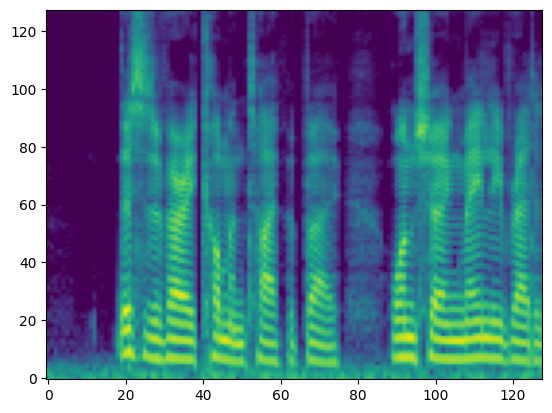

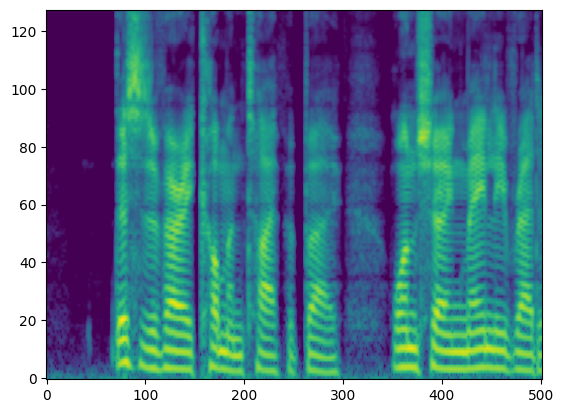

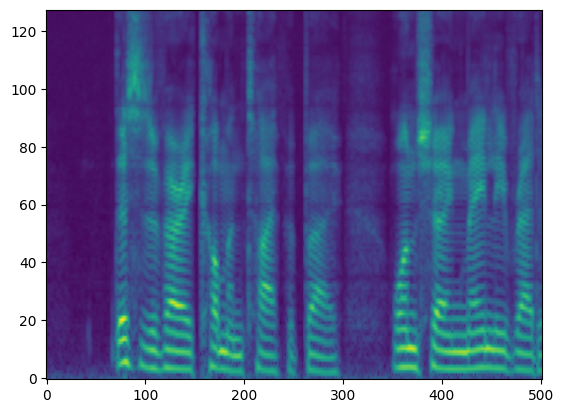

In [88]:
# org = mel_spec.detach().clone()
# db = torch.pow(mel_spec.detach().clone(), 0.125)
# inv = torch.pow(db.detach().clone(), 1/0.125)
def my_power2db(spec):
    return torch.pow(spec, 0.125)
def my_db2power(spec):
    return torch.pow(spec, 1/0.125)
ds_s, ds_w = ds.getitem_helper('./noise_enhance/data/clean_testset/p226_024.wav')
pr_s, filterbank, scale = processor.wav_to_melspec(ds_w.unsqueeze(0))
assert ((db_to_power(power_to_db(pr_s)) - pr_s)**2).sum() < 1e-8
print(ds_s.shape, ds_w.shape, pr_s.shape)
plot_spectrogram(ds_s[0].cpu().numpy())
plot_spectrogram(power_to_db(pr_s)[0].cpu().numpy())
plot_spectrogram(my_power2db(pr_s)[0].cpu().numpy())

In [83]:
# Find max, min in normalization
from utils import power_to_db, db_to_power
datadir = './noise_enhance/data/noisy_trainset'
maxval, minval = -float('inf'), float('inf')
for f in tqdm(os.listdir(datadir)):
    wav, sr = torchaudio.load(os.path.join(datadir, f))
    mel_spec, filterbank, scale = processor.wav_to_melspec(wav.to('cuda'))
    # mel_spec = mel_spec**0.125
    mel_spec = power_to_db(mel_spec)
    maxval = max(mel_spec.max(), maxval)
    minval = min(mel_spec.min(), minval)
# power (SE clean train): (1.4672e-15, 3.6481)
# db (SE clean train): (-100., 5.6207)
# db (SE noisy train): (-96.5981, 4.6624)
# author (**0.125) (SE clean train): (0.0140, 1.1756)
# author (**0.125) (SE noisy train): (0.0318, 1.1436)
minval, maxval

  0%|          | 2/11000 [00:00<10:08, 18.09it/s]

100%|██████████| 11000/11000 [05:12<00:00, 35.20it/s]


(tensor(-96.5981, device='cuda:0'), tensor(4.6624, device='cuda:0'))

In [57]:
# from collections import defaultdict

# noisydir = './PD_enhance/data/noisy_testset_2'
# cleandir = './PD_enhance/data/clean_testset_2'
# noisyfiles = os.listdir(noisydir)
# cleanfiles = os.listdir(cleandir)
# print(len(cleanfiles) == len(noisyfiles), len(set(cleanfiles)) == len(cleanfiles))
# print(all([f in set(noisyfiles) for f in cleanfiles]), len(cleanfiles), len(noisyfiles))

# traindir = './PD_enhance/data/clean_trainset_2'
# testdir = './PD_enhance/data/clean_testset_2'
# # os.mkdir('./PD_enhance/data/clean_trainset_2')
# # os.mkdir('./PD_enhance/data/clean_testset_2')
# # os.mkdir('./PD_enhance/data/noisy_trainset_2')
# # os.mkdir('./PD_enhance/data/noisy_testset_2')

# d = defaultdict(int)
# for f in os.listdir(traindir):
#     filename = f.replace('.wav', '')
#     if filename[:-4]=="70db": # "sim_oc11_habitual_nm_h15_10_ch1_70db"
#         list_id = filename.split("_")[4][1:]  # h15 -> 15
#         sent_id = filename.split("_")[5]
#     else: # "sim_NM_amp_babble_oc02_h17_1"
#         list_id = filename.split("_")[5][1:]  # h17 -> 17
#         sent_id = filename.split("_")[6]
#     list_id, sent_id = int(list_id), int(sent_id)
#     d[list_id] += 1

#     if list_id == 14:
#         print(f)
#         # shutil.move(os.path.join(traindir, f), os.path.join(testdir, f))
# d

defaultdict(int, {15: 29, 2: 19, 10: 9})